In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import math
from skimage.feature import blob_log
from apsg import *

microm2m = 1.0E-6
m2microm = 1.0E6

plt.rcParams["figure.figsize"] = (10,10)

In [2]:
def cartesian_components(D, I, Q, R):
    
    """
    Calculates the cartesian components of  natural remanent magnetization (NRM)
    for uniformily magnetized spheres (mx, my, mz) required in the forward model.

    Parameters:
        * D: 1D-array containing magnetization declination (0 to 360 degrees)
        * I: 1D-array containing magnetization inclination (-90 to 90  degress)
        * Q: 1D-array containing magnetization intensity (A/m)
        * R: 1D-array containing sphere's radius (m)

    Constant:
        * cm: is a constant given by 4*np.pi/µo = 10**(-7) 
            where µo is the vaccum magnetic permeability
    """
    
    
    cm = 10**(-7) # H/m  == T·m/A
    m = []

    for i in range(np.size(D)):
        m_sphere =  np.matrix([[(Q[i]*np.cos(I[i]*(np.pi/180))*np.cos(D[i]*(np.pi/180))) * ((cm*4.0*np.pi*R[i]**3)/3.0) ],
                          [(Q[i]*np.cos(I[i]*(np.pi/180))*np.sin(D[i]*(np.pi/180))) * ((cm*4.0*np.pi*R[i]**3)/3.0) ],
                           [(Q[i]*np.sin(I[i]*(np.pi/180)))*((cm*4.0*np.pi*R[i]**3)/3.0)                            ]])

        m = np.append(m,m_sphere)
        
    return(np.array(m))



def sensibility_matrix(X, Y, Z, Xc, Yc, Zc): 
    
    """
    Generates the sensibility matrix for vertical component of magnetization

    Parameters:
        *  X,  Y,  Z: 1D-arrays with x, y and z data positions
        * Xc, Yc, Zc: 1D-arrays with x, y and z data  of the sphere's center positions
    """

    dzz = np.zeros(np.shape(Z))
    dxz = np.zeros(np.shape(Z))
    dzy = np.zeros(np.shape(Z))


    for j in range(len(Xc)):
        for i in range(len(X)):
            dzz[i] =  -1.0*( (X[i]-Xc[j])**2+(Y[i]-Yc[j])**2-2*(Z[i]-Zc[j])**2) / (  ((X[i]-Xc[j])**2+(Y[i]-Yc[j])**2+(Z[i]-Zc[j])**2) )**(5/2)
            dxz[i] = ( 3.0*(X[i]-Xc[j])*(Z[i]-Zc[j]) ) / (  ((X[i]-Xc[j])**2+(Y[i]-Yc[j])**2+(Z[i]-Zc[j])**2) )**(5/2)
            dzy[i] = ( 3.0*(Z[i]-Zc[j])*(Y[i]-Yc[j]) ) / (  ((X[i]-Xc[j])**2+(Y[i]-Yc[j])**2+(Z[i]-Zc[j])**2) )**(5/2)
            
        M = ([[dxz],[dzy],[dzz]])
        
        M = np.reshape(M, (3, np.size(dzz)))
        M.T
        
        if j==0:
            Mz = np.copy(M)
        else:
            Mz = np.concatenate((Mz,M), axis=0)


    return(Mz.T) # sensibility matrix                    
    


def regular(area, shape, z=None):
    
    """
    Generates the regular grid --> source https://legacy.fatiando.org/cookbook.html

    Parameters:
        * area: array with x axis size (nx) and y axis size (ny)
        * shape: array with min(x), max(x), min(y) and max(y)
        * z: float with the distance between the sample surface and the sensor
    """
    
    nx, ny = shape
    x1, x2, y1, y2 = area
    xs = np.linspace(x1, x2, nx)
    ys = np.linspace(y1, y2, ny)
    
    arrays = np.meshgrid(ys, xs)[::-1]
    
    if z is not None:
        arrays.append(z*np.ones(nx*ny, dtype=np.float64))
    return [i.ravel() for i in arrays]



def noise(data, error=0.05):
    
    """
    Generates a Gaussian noise (normal distribution, mean equals zero, and desv. pad. equals the error percent input)

    Parameters:
        * data: simulated data vector
        * percent_erro: error percentage (default = 5%) based on the maximum amplitude of the anomaly 

    """
    
    sigma_noise = (np.absolute(np.max(data))+np.absolute(np.min(data))) * error
    noise_vector = np.array(np.random.normal(0,sigma_noise,len(data)))
    noise_vector = np.transpose(noise_vector)

    data_noise = data+noise_vector
 
    return (data_noise)


def derivative_fd(data_2D, X, Y, order=1):
    x_derivative=np.zeros(np.shape(data_2D))
    y_derivative=np.zeros(np.shape(data_2D))
    
    
    for i in range(np.shape(X)[0]-1):
        for j in range(np.shape(Y)[1]-1):
            x_derivative[i,j]=np.array((data_2D[i+1,j]-data_2D[i-1,j])/(X[i+1,j]-X[i-1,j]))
            y_derivative[i,j]=np.array((data_2D[i, j+1]-data_2D[i,j-1])/(Y[i,j+1]-Y[i,j-1]))
            
    if order>1:
        x_derivative, _  = derivative_fd(x_derivative, X, Y, order=order-1)
        _,  y_derivative = derivative_fd(y_derivative, X, Y, order=order-1)
            
    
    
    # boundary conditions
    x_derivative[ 0, :] = x_derivative[1 , :]
    x_derivative[-1, :] = x_derivative[-2, :]
    y_derivative[: , 0] = y_derivative[: , 1]
    y_derivative[: ,-1] = y_derivative[: ,-2]
    
    
    return(x_derivative, y_derivative)



def wave_numbers(data_2D, X, Y): 
    
    wx = np.zeros(np.shape(data_2D))
    wy = np.zeros(np.shape(data_2D))
    
    nx, ny = np.shape(data_2D)
    y_step = (np.max(Y) - np.min(Y)) / (ny-1)
    x_step = (np.max(X) - np.min(X)) / (nx-1)
    
    # x frequency
    for j in range(np.shape(data_2D)[1]):
        kx = np.fft.fftfreq(nx, x_step)
        wx[:,j] = 2*np.pi*kx  # wave number in x direction

    # y frequency
    for i in range(np.shape(data_2D)[0]):
        ky = np.fft.fftfreq(ny, y_step)
        wy[i,:] = 2*np.pi*ky   # wave number in y direction
    
    # radial wave number
    wz = np.sqrt(wx**2+wy**2) 

    return(wx, wy, wz)



def y_derivative_fft(data_2D, wy, order=1): 
    
    f_hat = np.fft.fft2(data_2D)
    derivative_factor = (1j*wy)**order
    
    y_derivative = np.real(np.fft.ifft2(derivative_factor*f_hat))
    
    # boundary conditions
    y_derivative[0 , :] = y_derivative[1 , :]
    y_derivative[-1, :] = y_derivative[-2, :]
    y_derivative[: , 0] = y_derivative[: , 1]
    y_derivative[: ,-1] = y_derivative[: ,-2]
    
    return(y_derivative)



def x_derivative_fft(data_2D, wx, order=1): 
    
    f_hat = np.fft.fft2(data_2D)
    derivative_factor = (1j*wx)**order
    
    x_derivative = np.real(np.fft.ifft2(derivative_factor*f_hat))
    
    # boundary conditions
    x_derivative[0 , :] = x_derivative[1 , :]
    x_derivative[-1, :] = x_derivative[-2, :]
    x_derivative[: , 0] = x_derivative[: , 1]
    x_derivative[: ,-1] = x_derivative[: ,-2]

    return(x_derivative)



def z_derivative_fft(data_2D, wz, order=1): 
    
    f_hat = np.fft.fft2(data_2D)
    derivative_factor = wz**order
    
    z_derivative = np.real(np.fft.ifft2(derivative_factor*f_hat))
    
    # boundary conditions
    z_derivative[0 , :] = z_derivative[1 , :]
    z_derivative[-1, :] = z_derivative[-2, :]
    z_derivative[: , 0] = z_derivative[: , 1]
    z_derivative[: ,-1] = z_derivative[: ,-2]
    
    return(z_derivative)



def upward_continuation(data_2D, delta_z, wz):
    
    f_hat = np.fft.fft2(data_2D)                 
    up_cont_factor = np.exp((delta_z)*(wz))
    
    up_cont = np.real(np.fft.ifft2(f_hat*up_cont_factor))
    
    # boundary conditions
    up_cont[ 0, :] = up_cont[1 , :]
    up_cont[-1, :] = up_cont[-2, :]
    up_cont[: , 0] = up_cont[: , 1]
    up_cont[: ,-1] = up_cont[: ,-2]
    
    return(up_cont)



def z_derivative_fd(upward_1, upward_2, delta_Z1, delta_Z2):
    z_derivative = np.zeros(np.shape(upward_1))
        
    for i in range(np.shape(upward_1)[0]-1):
        for j in range(np.shape(upward_1)[1]-1):
            z_derivative[i,j]=np.array((upward_1[i,j]-upward_2[i,j])/(np.absolute(delta_Z2 - delta_Z1)))
    
    return(z_derivative)




def Horiz_Grad(x_derivative, y_derivative): 
    
    horizontal_gradient = np.sqrt(np.absolute(y_derivative**2+x_derivative**2))
    
    return(horizontal_gradient)



def sources_finder(Horiz_Grad, data = [], threshold=0.05, min_sigma=1, max_sigma=100, num_sigma=50, overlap=0.5, radius_increment=0.2):
    
    input_data = (Horiz_Grad / Horiz_Grad.max())  # normalized data (0<= data <=1)
    
    blobs_log = blob_log(input_data,  min_sigma=min_sigma, max_sigma=max_sigma, num_sigma=num_sigma, threshold = threshold, overlap=overlap)

    # Compute radii in the 3rd column.
    blobs_log[:, 2] = blobs_log[:, 2] * np.sqrt(2)

    blobs_list = [blobs_log]
    colors = ['yellow']
    titles = ['Localização de Fontes (Laplacian of Gaussian)']
    sequence = zip(blobs_list, colors, titles)

    circles = []

    fig = plt.figure(figsize=(9, 5))
    ax = fig.add_subplot(1, 1, 1)
    for idx, (blobs, color, title) in enumerate(sequence):
        plt.title(title, fontsize=18)
        
        if np.size(data)==0:
            plt.imshow(input_data)
        else:
            plt.imshow(data)
        plt.gca().invert_yaxis()
        for blob in blobs:
            y, x, r = blob
            if (r>=2): 
                circles = np.append(circles, [np.round(y),np.round(x),np.round(r + radius_increment*r)])
                c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
                ax.add_patch(c)

    plt.tight_layout()
    plt.show()
    
    
    circles_T = np.reshape(circles, (int(np.size(circles)/3),3))

                
    ###################################
    
    # remove larger circles wrappind smaller ones
    circles_teste = []
    for i in range(np.shape(circles_T)[0]):
        for j in range(np.shape(circles_T)[0]):
            center_distance = np.sqrt( (circles_T[i, 0]-circles_T[j, 0])**2 + (circles_T[i, 1]-circles_T[j, 1])**2 )
            radius_sum = np.absolute(circles_T[i, 2] + circles_T[j, 2])
            radius_dif = np.absolute(circles_T[i, 2] - circles_T[j, 2])
             
            if i != j:
                if (center_distance <= radius_dif) or (center_distance <= 0.5*radius_sum) or (int(center_distance)==0):
                #if ((center_distance + circles_T[j, 2]) < circles_T[i, 2]):
                    if circles_T[i, 2] < circles_T[j, 2]:
                        circles_teste.append(circles_T[j, 0])
                        circles_teste.append(circles_T[j, 1])
                        circles_teste.append(circles_T[j, 2])

                    

    circles_teste = np.reshape(circles_teste, (int(np.size(circles_teste)/3),3))

    for i in circles_teste:  
        bubble = []
        delete = (circles_T==i)
        for j in range(np.shape(delete)[0]):
            if delete[j, 0]==True & delete[j, 1]==True & delete[j, 2]==True:
                bubble.append(True)
            else:
                bubble.append(False)
        circles_T = np.delete(circles_T, bubble, 0)
    
    #####################################

    
    euler_windows = []

    for i in range(np.shape(circles_T)[0]):
            x1 = int(circles_T[i,0]-circles_T[i,2])
            x2 = int(circles_T[i,0]+circles_T[i,2])
            y1 = int(circles_T[i,1]-circles_T[i,2])
            y2 = int(circles_T[i,1]+circles_T[i,2])
            
            if (x1>=0) & (x2<=np.shape(input_data)[0]) & (y1>=0) & (y2<=np.shape(input_data)[1]):         
                euler_windows = np.append(euler_windows, ([x1, x2, y1, y2]) )
                
    euler_windows_T = np.reshape(euler_windows, (int(np.size(euler_windows)/4),4))

    return(circles, euler_windows_T)

    

    
def euler_windows_view(X_, Y_, Z_, d_, ddx, ddy, ddz, euler_windows_T, show_windows=False, color='y'):
    
    nx, ny = np.shape(d_)
    y_step = (np.max(Y_)*m2microm - np.min(Y_)*m2microm) / (ny-1)
    x_step = (np.max(X_)*m2microm - np.min(X_)*m2microm) / (nx-1)
    
    plt.figure()
    plt.contourf(Y_*m2microm, X_*m2microm, d_, cmap='jet')
    
    for i in range(np.shape(euler_windows_T)[0]):
        x1 = int(euler_windows_T[i,0]) * x_step
        x2 = int(euler_windows_T[i,1]) * x_step
        y1 = int(euler_windows_T[i,2]) * y_step
        y2 = int(euler_windows_T[i,3]) * y_step
        
        plt.hlines(x1, y1, y2, color=color)
        plt.hlines(x2, y1, y2, color=color)
        plt.vlines(y1, x1, x2, color=color)
        plt.vlines(y2, x1, x2, color=color)
    
    if show_windows:
    
        for i in range(np.shape(euler_windows_T)[0]):
            x1 = int(euler_windows_T[i,0])
            x2 = int(euler_windows_T[i,1])
            y1 = int(euler_windows_T[i,2])
            y2 = int(euler_windows_T[i,3])

            plt.figure()
            plt.contourf(Y_[x1:x2, y1:y2]*m2microm, X_[x1:x2, y1:y2]*m2microm, d_[x1:x2, y1:y2])
    

    
    return()
   

def solve_euler(X_, Y_, Z_, d_, ddx, ddy, ddz, delta_z, structural_index = 3.0):
    

    # first member --> components of A matrix
    d_X_ = np.array(np.reshape(ddx, (np.size(ddx),1)))
    d_Y_ = np.array(np.reshape(ddy, (np.size(ddy),1)))
    d_Z_ = np.array(np.reshape(ddz, (np.size(ddz),1)))
    ni   = np.array(np.ones(np.shape(d_X_))*structural_index)

    A = np.zeros((np.size(d_X_), 4))
    A[:,0] = d_X_[:,0]
    A[:,1] = d_Y_[:,0]
    A[:,2] = d_Z_[:,0]
    A[:,3] =   ni[:,0]

    # second member --> vector B
    X_1  = np.array(np.reshape(X_, (np.size(X_),1)))
    Y_1  = np.array(np.reshape(Y_, (np.size(Y_),1)))
    Z_1  = np.array(np.reshape(Z_, (np.size(Z_),1))) + delta_z
    ni_d = structural_index*d_
    ni_d_ = np.array(np.reshape(ni_d, (np.size(ni_d),1)))

    B = (X_1[:,:]*d_X_[:,:]) + (Y_1[:,:]*d_Y_[:,:]) + ((Z_1[:,:])*d_Z_[:,:])  + (ni_d_)

    # solving linear system using least square
    A_T = np.transpose(A)
    A_T_A = np.matmul(A_T, A)
    A_T_B = np.matmul(A_T, B)
    C = np.matmul(np.linalg.inv(A_T_A), A_T_B)
    
    return(C[0],C[1],C[2])




def solve_euler_windows(euler_windows, X_, Y_, Z_, d_, ddx, ddy, ddz, delta_z, structural_index = 3.0):
    euler_position = []
    for i in range(np.shape(euler_windows)[0]):
        x1 = int(euler_windows[i, 0])
        x2 = int(euler_windows[i, 1])
        y1 = int(euler_windows[i, 2])
        y2 = int(euler_windows[i, 3])
        source_position = solve_euler( X_[x1:x2, y1:y2], Y_[x1:x2, y1:y2], Z_[x1:x2, y1:y2], d_[x1:x2, y1:y2], 
                                      ddx[x1:x2, y1:y2], ddy[x1:x2, y1:y2], ddz[x1:x2, y1:y2], 
                                      delta_z, structural_index = 3.0)
        euler_position = np.append(euler_position, source_position)

    euler_position = np.reshape(euler_position, (int(np.size(euler_position)/3),3))
    
    Xc = []
    Yc = []
    Zc = []
    
    for row in range (np.shape(euler_position)[0]):
        Xc = np.append(Xc, euler_position[row, 0] )
        Yc = np.append(Yc, euler_position[row, 1] )
        Zc = np.append(Zc, euler_position[row, 2] )
        
    
    return(Xc, Yc, Zc)



def least_square_solver(X, Y, Z, Xc, Yc, Zc, d):

    M = sensibility_matrix(X, Y, Z, Xc, Yc, Zc)
    h = np.linalg.solve(M.T@M, M.T@d)
    
    
    w = int(np.size(h))
    h_T = np.reshape(h, (int(w/3),3) )
    
    hx = []
    hy = []
    hz = []
    
    for row in range (np.shape(h_T)[0]):
        hx = np.append(hx, h_T[row, 0] )
        hy = np.append(hy, h_T[row, 1] )
        hz = np.append(hz, h_T[row, 2] )
        
    
    return(hx, hy, hz, M)





def directions(hx, hy, hz, plot = False, show_mean = False, show_alpha95 = False):
    D = []
    I = []
    
#     I_mean = ((math.atan2( np.mean(hz), (np.sqrt(np.mean(hy)**2 + np.mean(hx)**2)) ) )* (180/np.pi))
#     D_mean = ((math.atan2( np.mean(hy),  np.mean(hx)) * (180/np.pi) ) )
    
    for i in range (np.size(hx)):

        I = np.append( I, (math.atan2( hz[i], (np.sqrt(hy[i]**2+hx[i]**2)) ) )* (180/np.pi))
        D = np.append( D, (math.atan2( hy[i],  hx[i] ) * (180/np.pi) ) )
            
        
    if plot == True:
        settings['figsize'] = (7, 7)
        
        s = StereoNet(grid=True, legend=True)
        s.title('Recovered Directions')
        
        group = []
        
        for w in range (np.size(D)):
            
            if I[w] >= 0:
                symbol = '.'
                color = 'r'
            else:
                symbol = '.'
                color = 'k'
            
            if w == 0:
                s.line((Lin(float(D[w]), np.round(np.absolute(I[w])))), color=color, marker=symbol)
                group.append((Lin(float(D[w]), np.round(np.absolute(I[w])))))

            else:
                s.line((Lin(float(D[w]), np.round(np.absolute(I[w])))), color=color, marker=symbol)
                group.append((Lin(float(D[w]), np.round(np.absolute(I[w])))))
        
        group = Group(group) # create a group variable with all lines
        
        if show_mean == True:
            mean = group.R
            s.line(mean,'b.')
#             s.line((Lin(float(D_mean), np.round(np.absolute(I_mean)))), color='b', marker='o')
#             print('Mean direction: '+str(D_mean)+' / '+str(I_mean))
        if show_alpha95 == True:
            s.cone(group.R, group.fisher_stats['a95'], 'b') # gives the a95 cone for the group


                             
    
    return(D, I)

    
    
def uncertainties(sigma_zero, M, hx, hy, hz):

    Cov_matrix = (sigma_zero**2)*np.linalg.inv(M.T@M)
    diag_cov_matrix = np.diag(Cov_matrix)
    
    
    sigma_hx = []
    sigma_hy = []
    sigma_hz = []
    
    i = -1
    
    while i <= (np.size(diag_cov_matrix)-2):
        i += 1
        sigma_hx = np.append(sigma_hx, diag_cov_matrix[i])
        
        i += 1
        sigma_hy = np.append(sigma_hy, diag_cov_matrix[i])
        
        i += 1
        sigma_hz = np.append(sigma_hz, diag_cov_matrix[i])
        


    
    dD_dhx = -hy/(hx**2+hy**2)
    dD_dhy = hx/(hx**2+hy**2)

    sigma_D = np.sqrt( ((dD_dhx)**2*(sigma_hx)) + ((dD_dhy)**2*(sigma_hy)) ) * (180/np.pi) 

        

    
    dI_dhx = (-hx*hz) / ( np.sqrt(hx**2+hy**2) * (hx**2 + hy**2 + hz**2)  )
    dI_dhy = (-hy*hz) / ( np.sqrt(hx**2+hy**2) * (hx**2 + hy**2 + hz**2)  )
    dI_dhz = (np.sqrt(hx**2+hy**2) ) / ((hx**2 + hy**2 + hz**2))

    sigma_I = np.sqrt( (dI_dhx)**2*(sigma_hx) + (dI_dhy)**2*(sigma_hy) + (dI_dhz)**2*(sigma_hz) ) * (180/np.pi) 

    return(sigma_D, sigma_I)
    

    
    
    



def robust_solver(X, Y, Z, Xc, Yc, Zc, d, tolerance=1.0E-5):

    M = sensibility_matrix(X, Y, Z, Xc, Yc, Zc)
    h = np.linalg.solve(M.T@M, M.T@d) # least square (Rk, k=0)
    e = 1.0E-20 # small positive value to avoid singularities
    
       
    # setting the diagonal matrix N x N
    r_k = 1/(np.absolute(np.matmul(M,h) - d + e))
    R_k = sp.sparse.diags(r_k , offsets=0, format='csc')


 
    break_condition = np.inf
    for i in range(1,11):

        print('iteration: ', i)
        
        bubble_h = np.copy(h) # for the breaking condition
        
        ### first iteration
        M_T = M.T
        M_T_R = (M_T@R_k)
        

        M_M_T_R = sp.sparse.csc_matrix(np.matmul(M_T_R, M)) # convert to csc to avoid format error
        d_M_T_R = np.matmul(M_T_R, d)


        h = sp.sparse.linalg.spsolve(M_M_T_R, d_M_T_R)
        
        norm_h_plus_one = np.linalg.norm(h) # for the breaking condition
        
       
        if break_condition<=tolerance:
            break
        

        #### recalculating R_k for the next iteration
        r_k = 1/(np.absolute(np.matmul(M,h) - d + e))
        R_k = sp.sparse.diags(r_k , offsets=0, format='csc')
        
        break_condition = np.linalg.norm(h-bubble_h)/(1+(norm_h_plus_one)) # following Aster et al. (2005)
    
    w = int(np.size(h))
    h_T = np.reshape(h, (int(w/3),3) )
    
    hx = []
    hy = []
    hz = []
    
    for row in range (np.shape(h_T)[0]):
        hx = np.append(hx, h_T[row, 0] )
        hy = np.append(hy, h_T[row, 1] )
        hz = np.append(hz, h_T[row, 2] )
        
    
    return(hx, hy, hz, M)


In [3]:
flight = 5.0  # sample-sensor distance
area = (0, 500*microm2m, 0, 500*microm2m)
shape = (500,500)
z = -flight*microm2m

f = np.matrix(regular(area, shape, z))
X = np.array(f[0])
Y = np.array(f[1])
Z = np.array(f[2])

cm = 10**(-7) # H/m  == T·m/A


# generates x sourcers
sourcers = 10
D = np.random.normal(45, 1, sourcers)
I = np.random.normal(45, 1, sourcers)
Q = np.random.normal(480000, 10, sourcers)
R = ( np.random.normal(0.5, 0.1, sourcers) )*microm2m

Xc = np.random.randint(30, 470, sourcers)*microm2m
Yc = np.random.randint(30, 470, sourcers)*microm2m
Zc = np.random.randint(1, 10, sourcers)*microm2m



m = cartesian_components(D, I, Q, R)
M = sensibility_matrix(X, Y, Z, Xc, Yc, Zc)


In [4]:
# data vector direct model
d = np.matmul(M, m)

#apply noise
d = noise(d, error=0.01)

# Reshape data vector for the map plot
d_= np.reshape(d, shape)

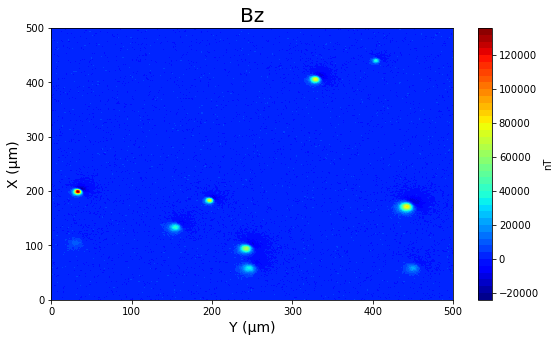

In [5]:
xs = np.linspace(area[0], area[1], shape[0])
ys = np.linspace(area[2], area[3], shape[1])

x_plot = np.reshape(Y,(np.size(xs),np.size(ys)))*m2microm
y_plot = np.reshape(X,(np.size(xs),np.size(ys)))*m2microm

# plot do mapa de dados do modelo direto

plt.figure(figsize=(9,5))
plt.contourf(x_plot, y_plot, d_*10**9, levels=50, cmap='jet')
plt.colorbar(label='nT')

plt.title('Bz', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)


plt.show()

In [6]:
X_ = np.reshape(X, shape)
Y_ = np.reshape(Y, shape)
Z_ = np.reshape(Z, shape)


# calculating derivatives using Fast Fourier Transform (FFT)

wx, wy, wz = wave_numbers(d_, X_, Y_)

ddx = x_derivative_fft(d_, wx, order=1)
ddy = y_derivative_fft(d_, wy, order=1)
ddz = z_derivative_fft(d_, wz, order=1)

# calculating derivatives (x and y) using Finite Differences (FD)
d_X, d_Y = (derivative_fd(d_, X_,Y_, order=1))


Text(0, 0.5, 'X (µm)')

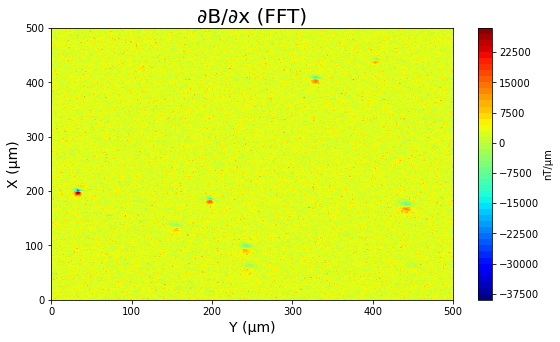

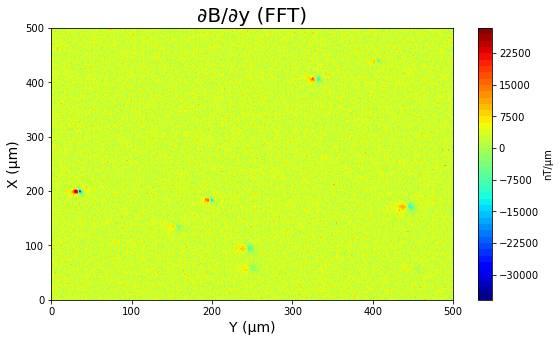

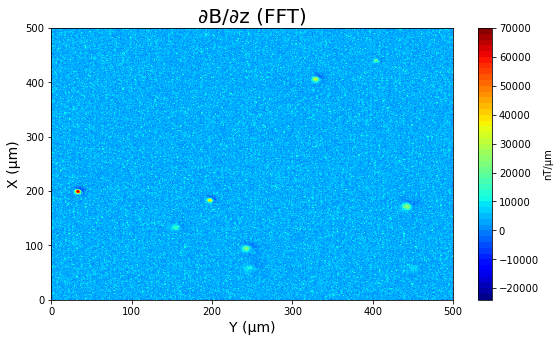

In [7]:
# plot FFT derivatives

plt.figure(figsize=(9,5))
plt.contourf(x_plot, y_plot, ddx*10**3, levels=50, cmap='jet')
plt.colorbar(label='nT/µm')

plt.title('∂B/∂x (FFT)', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)


plt.figure(figsize=(9,5))
plt.contourf(x_plot, y_plot, ddy*10**3, levels=50, cmap='jet')
plt.colorbar(label='nT/µm')

plt.title('∂B/∂y (FFT)', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)


plt.figure(figsize=(9,5))
plt.contourf(x_plot, y_plot, ddz*10**3, levels=50, cmap='jet')
plt.colorbar(label='nT/µm')

plt.title('∂B/∂z (FFT)', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)



Text(0, 0.5, 'X (µm)')

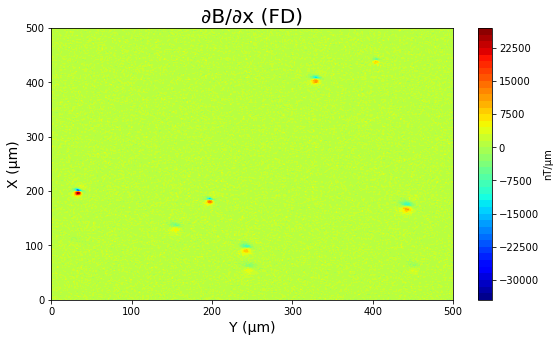

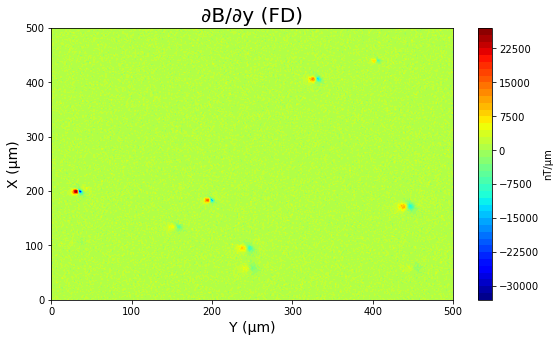

In [8]:
# plot FD derivatives

plt.figure(figsize=(9,5))
plt.contourf(x_plot, y_plot, d_X*10**3, levels=50, cmap='jet')
plt.colorbar(label='nT/µm')

plt.title('∂B/∂x (FD)', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)


plt.figure(figsize=(9,5))
plt.contourf(x_plot, y_plot, d_Y*10**3, levels=50, cmap='jet')
plt.colorbar(label='nT/µm')

plt.title('∂B/∂y (FD)', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)

In [9]:
# Calculating the horizontal gradient (GH) using FFT e FD

Horiz_Grad_FD = Horiz_Grad(d_Y , d_X)
Horiz_Grad_FFT = Horiz_Grad(ddy, ddx)

Text(0, 0.5, 'X (µm)')

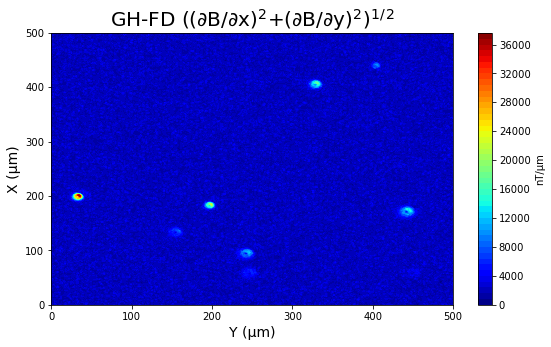

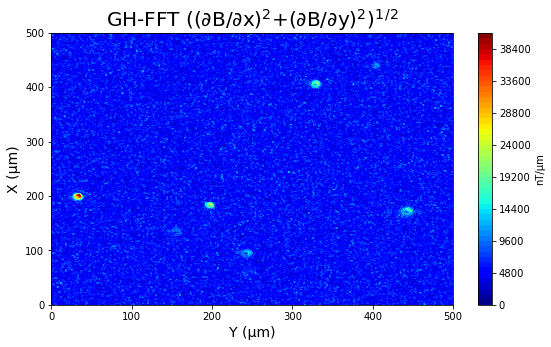

In [10]:
# plot FD horizontal gradient 
plt.figure(figsize=(9,5))
plt.contourf(x_plot, y_plot, Horiz_Grad_FD*10**3, levels=50, cmap='jet')
plt.colorbar(label='nT/µm')

plt.title('GH-FD'+' ((∂B/∂x)$^2$+(∂B/∂y)$^2$)$^1$$^/$$^2$', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)

# plot FFT horizontal gradient 
plt.figure(figsize=(9,5))
plt.contourf(x_plot, y_plot, Horiz_Grad_FFT*10**3, levels=50, cmap='jet')
plt.colorbar(label='nT/µm')

plt.title('GH-FFT'+' ((∂B/∂x)$^2$+(∂B/∂y)$^2$)$^1$$^/$$^2$', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)

In [11]:
# upward_continuation filtering --> to remove high frequency noise
height = 1.0      # delta_z upward continuation
delta_z = -height*microm2m
upward = upward_continuation(d_, delta_z, wz)


# upward_continuation --> used later to calculate the Z derivative by FD
delta_z1 = -(height-0.1)*microm2m
upward1 = upward_continuation(d_, delta_z1, wz)

delta_z2 = -(height+0.1)*microm2m
upward2 = upward_continuation(d_, delta_z2, wz)

Text(0, 0.5, 'X (µm)')

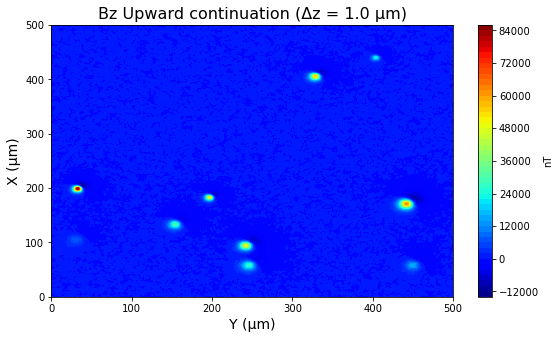

In [12]:
# upward continuation plot

plt.figure(figsize=(9,5))
plt.contourf(x_plot, y_plot, (upward)*10**9, levels=50, cmap='jet')
plt.colorbar(label='nT')

plt.title('Bz Upward continuation (Δz = %s µm)'%height, fontsize=16)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)



In [13]:
# New derivatives by FFT
ddy = y_derivative_fft(upward, wy)
ddx = x_derivative_fft(upward, wx)
ddz = z_derivative_fft(upward, wz)


Text(0, 0.5, 'X (µm)')

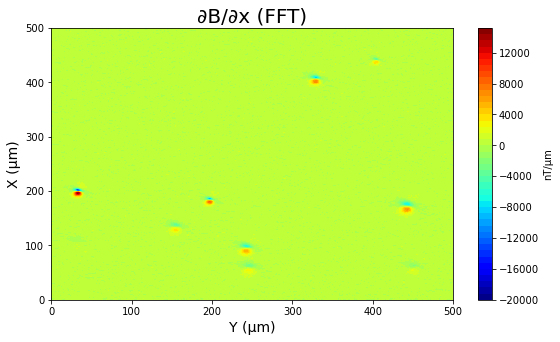

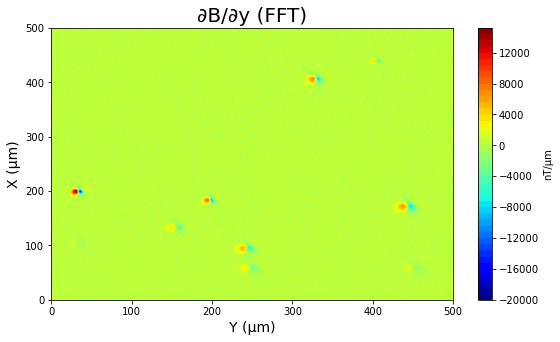

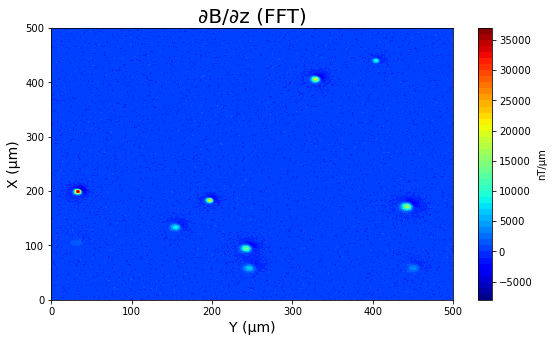

In [14]:
# Plot derivatives by FFT (after upward continuation)

plt.figure(figsize=(9,5))
plt.contourf(x_plot, y_plot, (ddx)*10**3, levels=50, cmap='jet')
plt.colorbar(label='nT/µm')

plt.title('∂B/∂x (FFT)', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)


plt.figure(figsize=(9,5))
plt.contourf(x_plot, y_plot, (ddy)*10**3, levels=50, cmap='jet')
plt.colorbar(label='nT/µm')

plt.title('∂B/∂y (FFT)', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)


plt.figure(figsize=(9,5))
plt.contourf(x_plot, y_plot, (ddz)*10**3, levels=50, cmap='jet')
plt.colorbar(label='nT/µm')

plt.title('∂B/∂z (FFT)', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)


In [15]:
# Novas derivadas (em x e y) usando a continuação p/ cima por FD
d_X, d_Y = (derivative_fd(upward, X_,Y_))
d_Z = z_derivative_fd(upward1, upward2, delta_z1, delta_z2)

Text(0, 0.5, 'X (µm)')

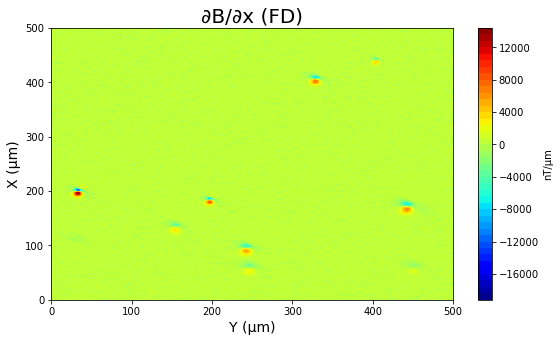

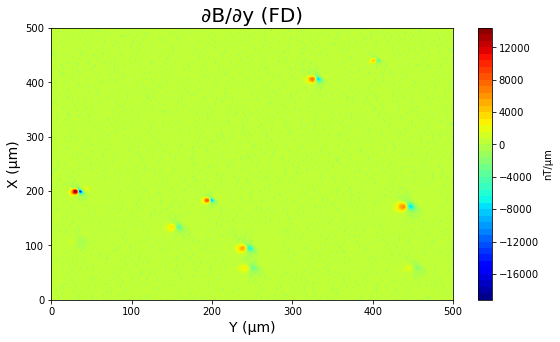

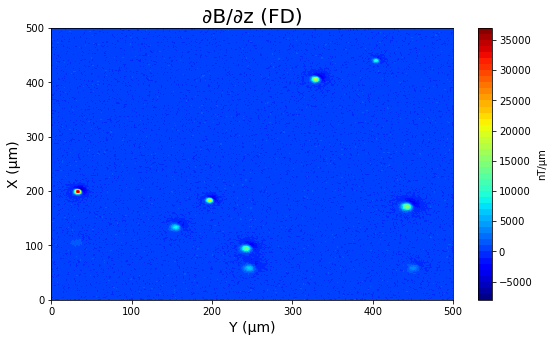

In [16]:
# Plot derivatives by FD (after upward continuation)

plt.figure(figsize=(9,5))
plt.contourf(x_plot, y_plot, (d_X)*10**3, levels=50, cmap='jet')
plt.colorbar(label='nT/µm')

plt.title('∂B/∂x (FD)', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)


plt.figure(figsize=(9,5))
plt.contourf(x_plot, y_plot, (d_Y)*10**3, levels=50, cmap='jet')
plt.colorbar(label='nT/µm')

plt.title('∂B/∂y (FD)', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)


#d_Z_ = np.reshape(d_Z, (shape))

plt.figure(figsize=(9,5))
plt.contourf(x_plot, y_plot, d_Z*10**3, levels=50, cmap='jet')
plt.colorbar(label='nT/µm')

plt.title('∂B/∂z (FD)', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)

In [17]:
Horiz_Grad_FD = Horiz_Grad(d_Y , d_X)
Horiz_Grad_FFT = Horiz_Grad(ddy, ddx)

Text(0, 0.5, 'X (µm)')

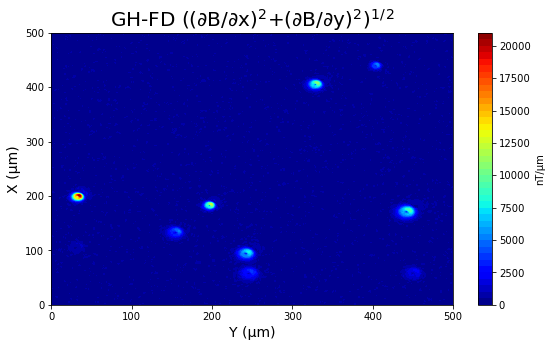

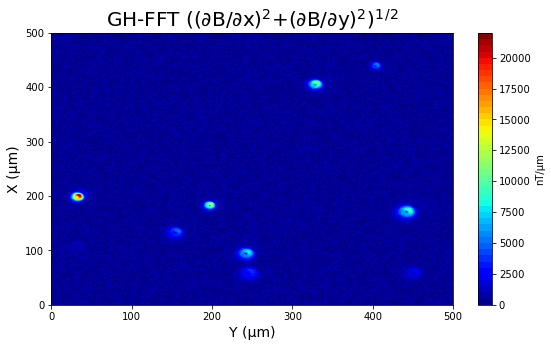

In [18]:
# plot FD horizontal gradient 
plt.figure(figsize=(9,5))
plt.contourf(x_plot, y_plot, Horiz_Grad_FD*10**3, levels=50, cmap='jet')
plt.colorbar(label='nT/µm')

plt.title('GH-FD'+' ((∂B/∂x)$^2$+(∂B/∂y)$^2$)$^1$$^/$$^2$', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)


# plot FFT horizontal gradient 
plt.figure(figsize=(9,5))
plt.contourf(x_plot, y_plot, Horiz_Grad_FFT*10**3, levels=50, cmap='jet')
plt.colorbar(label='nT/µm')

plt.title('GH-FFT'+' ((∂B/∂x)$^2$+(∂B/∂y)$^2$)$^1$$^/$$^2$', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)

# Euler solver

Text(0, 0.5, 'Count')

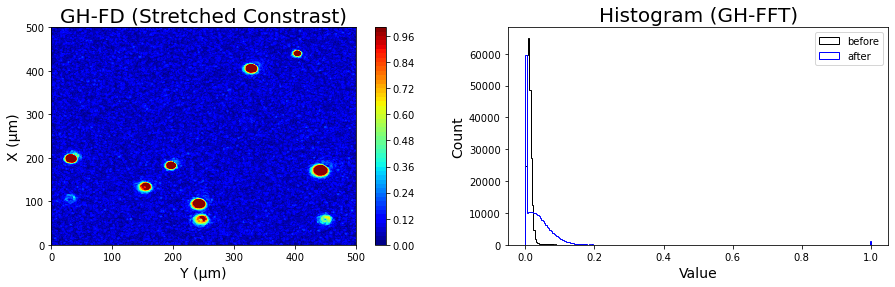

In [19]:
import skimage
import scipy.signal as signal

image =  Horiz_Grad_FD/Horiz_Grad_FD.max()

perc_min, perc_max = np.percentile(image, (20,99.5))
stretched_image = skimage.exposure.rescale_intensity(image, in_range=(perc_min, perc_max))

fig, ((ax1, ax2)) = plt.subplots(1,2, figsize=(15,4))

ax1_plot = ax1.contourf(x_plot, y_plot, stretched_image, levels=50, cmap='jet')
ax1.set_title('GH-FD (Stretched Constrast)', fontsize=20)
ax1.set_xlabel('Y (µm)', fontsize=14)
ax1.set_ylabel('X (µm)', fontsize=14)

plt.colorbar(ax1_plot, ax=ax1)

ax2.hist(image.ravel(), bins=256, histtype='step', color='k', label='before');
ax2.hist(stretched_image.ravel(), bins=256, histtype='step', color='b', label='after');
ax2.legend()
ax2.set_title('Histogram (GH-FFT)', fontsize=20)
ax2.set_xlabel('Value', fontsize=14)
ax2.set_ylabel('Count', fontsize=14)


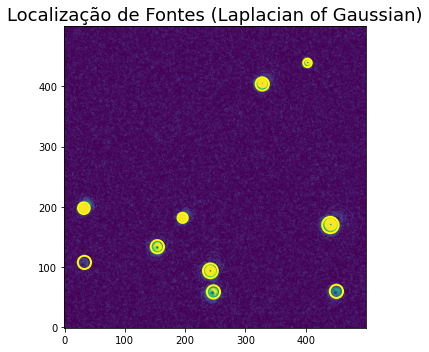

(10, 4)


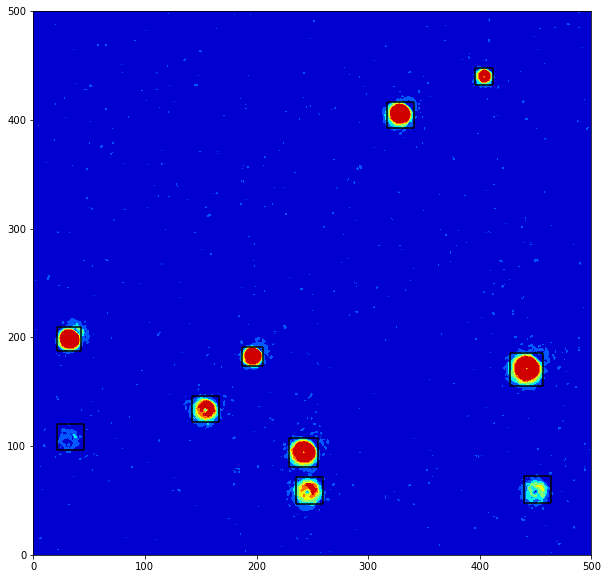

In [20]:
circles_FD, euler_windows_FD = sources_finder(stretched_image, threshold=0.05, min_sigma=5, max_sigma=50, num_sigma=50, overlap=1.0, radius_increment=0.1)
print(np.shape(euler_windows_FD))

import skimage
perc_min, perc_max = np.percentile(upward, (0.5,99.5))
upward_view = skimage.exposure.rescale_intensity(upward, in_range=(perc_min, perc_max))
euler_windows_view(X_, Y_, Z_, stretched_image, d_X, d_Y, d_Z, euler_windows_FD, show_windows=False, color='k')


Xc_FD, Yc_FD, Zc_FD = solve_euler_windows(euler_windows_FD, X_, Y_, Z_, upward, d_X, d_Y, d_Z, delta_z, structural_index = 3.0)

C:\Users\gelso\AppData\Local\Temp\ipykernel_10572\4114212114.py:8: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax1.scatter(Yc*m2microm, Xc*m2microm, Zc*m2microm, alpha=0.8, color='k', edgecolors='none', marker='+', s=50, label='Synthetic data')
C:\Users\gelso\AppData\Local\Temp\ipykernel_10572\4114212114.py:9: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax1.scatter(Yc_FD*m2microm, Xc_FD*m2microm, Zc_FD*m2microm, alpha=0.8, color='r', edgecolors='none', marker='x', s=50, label='FD')
C:\Users\gelso\AppData\Local\Temp\ipykernel_10572\4114212114.py:26: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facec

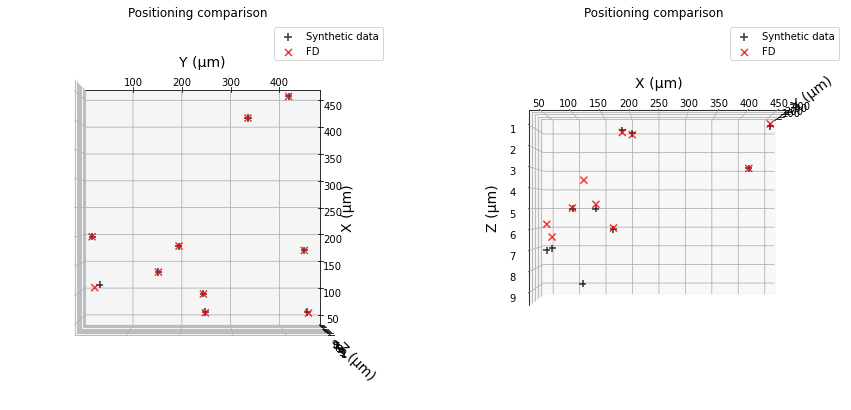

In [21]:
from mpl_toolkits.mplot3d import axes3d


fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

ax1.scatter(Yc*m2microm, Xc*m2microm, Zc*m2microm, alpha=0.8, color='k', edgecolors='none', marker='+', s=50, label='Synthetic data')
ax1.scatter(Yc_FD*m2microm, Xc_FD*m2microm, Zc_FD*m2microm, alpha=0.8, color='r', edgecolors='none', marker='x', s=50, label='FD')

ax1.set_title('Positioning comparison')
ax1.legend(loc='best')
ax1.invert_zaxis()

ax1.set_xlabel('Y (µm)', fontsize=14)
ax1.set_ylabel('X (µm)', fontsize=14)
ax1.set_zlabel('Z (µm)', fontsize=14)

ax1.azim = -90
ax1.dist = 10
ax1.elev = 90




ax2.scatter(Yc*m2microm, Xc*m2microm, Zc*m2microm, alpha=0.8, color='k', edgecolors='none', marker='+', s=50, label='Synthetic data')
ax2.scatter(Yc_FD*m2microm, Xc_FD*m2microm, Zc_FD*m2microm, alpha=0.8, color='r', edgecolors='none', marker='x', s=50, label='FD')

ax2.set_title('Positioning comparison')
ax2.legend(loc='best')
ax2.invert_zaxis()

ax2.set_xlabel('Y (µm)', fontsize=14)
ax2.set_ylabel('X (µm)', fontsize=14)
ax2.set_zlabel('Z (µm)', fontsize=14)

ax2.azim = 0
ax2.dist = 10
ax2.elev = 0

plt.show()

# Magnetic inversion using lest square method

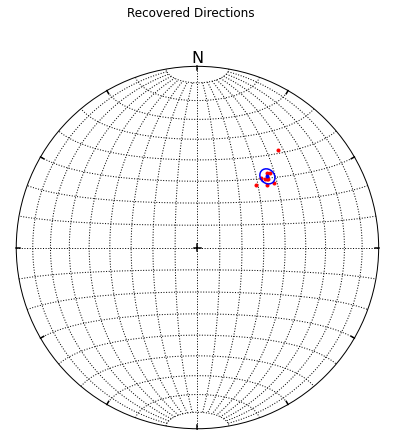

In [22]:
# Magnetic inversion using FD euler positions and magnetic data before the upward continuation

hx_FD, hy_FD, hz_FD, M_FD = least_square_solver(X, Y, Z, Xc_FD, Yc_FD, Zc_FD, d)

# print(hx_FD)
# print(hy_FD)
# print(hz_FD)

D_FD, I_FD = directions(hx_FD, hy_FD, hz_FD, plot=True, show_mean=True, show_alpha95=True)

# print(D_FD)
# print(I_FD)

# print()

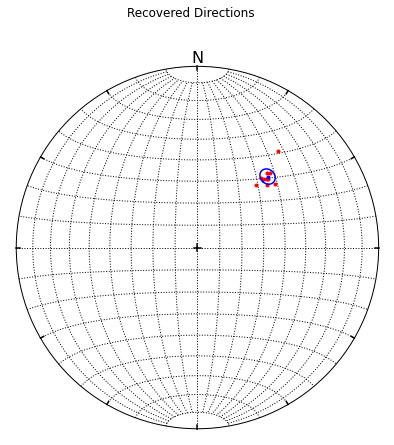

In [23]:
# rearrange upward data into a column array and squeeze to avoid errors with scipy.sparse.diags()
upward_data = np.squeeze(np.reshape(upward, (np.size(upward),1))) 


# Magnetic inversion using FD euler positions and magnetic data after the upward continuation

hx_FD, hy_FD, hz_FD, M_FD = least_square_solver(X, Y, Z, Xc_FD, Yc_FD, Zc_FD, upward_data)

# print(hx_FD)
# print(hy_FD)
# print(hz_FD)

D_FD, I_FD = directions(hx_FD, hy_FD, hz_FD, plot=True, show_mean=True, show_alpha95=True)

# print(D_FD)
# print(I_FD)

# print()

# Magnetic inversion using robust method

iteration:  1
iteration:  2
iteration:  3
iteration:  4
iteration:  5
iteration:  6
iteration:  7
iteration:  8
iteration:  9
iteration:  10


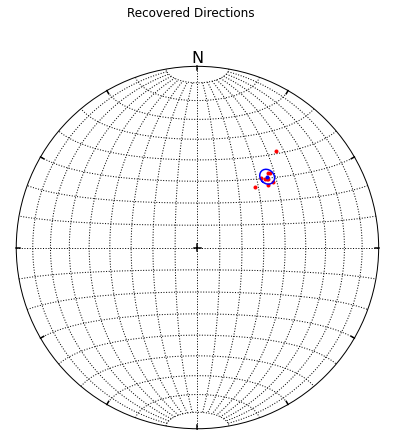

In [32]:
# Magnetic inversion using FD euler positions and magnetic data before the upward continuation

hx_FD, hy_FD, hz_FD, M_FD = robust_solver(X, Y, Z, Xc_FD, Yc_FD, Zc_FD, d, tolerance=0.0)

# print(hx_FD)
# print(hy_FD)
# print(hz_FD)

D_FD, I_FD = directions(hx_FD, hy_FD, hz_FD, plot=True, show_mean=True, show_alpha95=True)

# print(D_FD)
# print(I_FD)

# print()

iteration:  1
iteration:  2
iteration:  3
iteration:  4
iteration:  5
iteration:  6
iteration:  7
iteration:  8
iteration:  9
iteration:  10


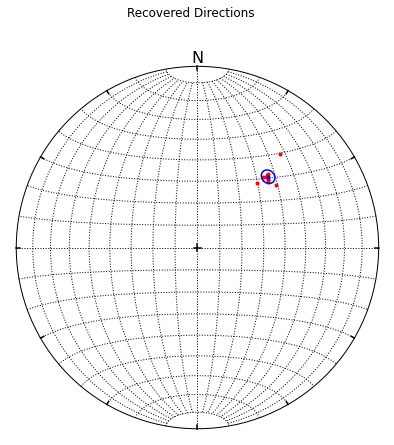

In [25]:
# rearrange upward data into a column array and squeeze to avoid errors with scipy.sparse.diags()
upward_data = np.squeeze(np.reshape(upward, (np.size(upward),1))) 


# Magnetic inversion using FD euler positions and magnetic data after the upward continuation

hx_FD, hy_FD, hz_FD, M_FD = robust_solver(X, Y, Z, Xc_FD, Yc_FD, Zc_FD, upward_data, tolerance=0.0)

# print(hx_FD)
# print(hy_FD)
# print(hz_FD)

D_FD, I_FD = directions(hx_FD, hy_FD, hz_FD, plot=True, show_mean = True, show_alpha95 = True)

# print(D_FD)
# print(I_FD)

# print()

# Magnetic inversion uncertainties

In [37]:
sigma_noise = (np.absolute(np.max(d))+np.absolute(np.min(d))) * 0.005
sigma_D_FD, sigma_I_FD = uncertainties(sigma_noise, M_FD, hx_FD, hy_FD, hz_FD)

print(sigma_D_FD)
print(sigma_I_FD)

[ 2.32920514  3.80018145  2.98796172  2.07798984  2.94825178 10.23189146
  4.29486635  4.55537799  7.57726151 13.33538249]
[1.40029758 2.33010392 1.80707255 1.2727046  1.7680481  5.71543541
 2.70838073 2.80678585 4.72102728 9.05267806]
